In [1]:
import os
import numpy as np
import random
from PIL import Image
from osgeo import gdal
from matplotlib import pyplot as plt


In [10]:
DATA_PATH = '/farmshare/user_data/ctoups22' #replace ctoups22 with your own user / data path
FORESTS_PATH = os.path.join(DATA_PATH, "ImagesGoogleMapsForests")
ORCHARDS_PATH = os.path.join(DATA_PATH, "ImagesGoogleMapsOrchards")
FORESTS_TIF_PATH = os.path.join(DATA_PATH, "planetImageryForests")
ORCHARDS_TIF_PATH = os.path.join(DATA_PATH, "planetImageryOrchards")
random.seed(25)

In [4]:
def calculate_rgb_simple_stats(path):
    res_means = []
    res_vars = []
    for i, filename in enumerate(os.listdir(path)):
        if i % 200 == 0:
            print(i)
        with Image.open(os.path.join(path, filename)) as im:
            np_img = np.asarray(im)
        res_means.append(np.mean(np_img, axis=(0,1)))
        res_vars.append(np.std(np_img, axis=(0,1)))
    var = np.mean(np.array(res_vars), axis=0)
    means = np.mean(np.array(res_means), axis=0)
    return var,means

In [5]:
orchards_stats = calculate_rgb_simple_stats(ORCHARDS_PATH)
forests_stats = calculate_rgb_simple_stats(FORESTS_PATH)

0
200
400
600
800
1000
1200
1400
1600
1800
0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400


In [6]:
orchard_vars = orchards_stats[0]
orchards_means = orchards_stats[1]
forest_vars = forests_stats[0]
forest_means = forests_stats[1]

In [7]:
def calibrate_image(rgb_image, ref_stds, ref_means):
    # Transform test image to 32-bit floats to avoid 
    # surprises when doing arithmetic with it 
    calibrated_img = rgb_image.copy().astype('float32')

    # Loop over RGB
    for i in range(3):
        # Subtract mean 
        calibrated_img[:,:,i] = calibrated_img[:,:,i]-np.nanmean(calibrated_img[:,:,i])
        # Normalize variance
        calibrated_img[:,:,i] = calibrated_img[:,:,i]/np.nanstd(calibrated_img[:,:,i])
        # Scale to reference 
        calibrated_img[:,:,i] = calibrated_img[:,:,i]*ref_stds[i] + ref_means[i]
        # Clip any values going out of the valid range
        calibrated_img[:,:,i] = np.clip(calibrated_img[:,:,i],0,255)

    # Convert to 8-bit unsigned int
    return calibrated_img.astype('uint8')

# 'i' is the starting index. If you want the first months RGB, then pass i = 1, for example. 
# month two would start at i=5
def get_rgb_from_tif(tif_dataset_object, i):
    band = tif_dataset_object.GetRasterBand(i)
    blue = band.ReadAsArray()
    
    band = tif_dataset_object.GetRasterBand(i+1)
    green = band.ReadAsArray()
    
    band = tif_dataset_object.GetRasterBand(i+2)
    red = band.ReadAsArray()
    
    rgb = np.stack((red, green, blue), axis=2)
    return rgb


In [8]:
def correct_image(full_path, columns=None, i=None, len_images=None):
    gdal_dataset = gdal.Open(full_path)
    rgb = get_rgb_from_tif(gdal_dataset, i=1)
    test_image_calibrated = calibrate_image(rgb, forest_vars, forest_means)
    if columns:
        plt.subplot(len_images / columns + 1, columns, i + 1)
    plt.imshow(test_image_calibrated)


#good ones = [way659611919.tif, ]
def generate_corrected_images(directory_path):
    dir_tif_images = os.listdir(directory_path)
    test_image_paths = random.sample(dir_tif_images, 5)
    print(test_image_paths)
    plt.figure(figsize=(20,10))
    columns = 3
    for i, path in enumerate(test_image_paths):
        correct_image(os.path.join(directory_path, path), columns, i, len(test_image_paths))
#         gdal_dataset = gdal.Open(os.path.join(directory_path, path))
#         rgb = get_rgb_from_tif(gdal_dataset, i=1)
#         test_image_calibrated = calibrate_image(rgb, forest_vars, forest_means)
#         plt.subplot(len(test_image_paths) / columns + 1, columns, i + 1)
#         plt.imshow(test_image_calibrated)


['way308137254.tif', 'way91308219.tif', 'way875193276.tif', 'way308455601.tif', 'way630788024.tif']
(53, 53, 3)
(51, 36, 3)


/home/ctoups22/miniconda3/envs/cs325b/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


(292, 275, 3)
(37, 81, 3)
(14, 19, 3)


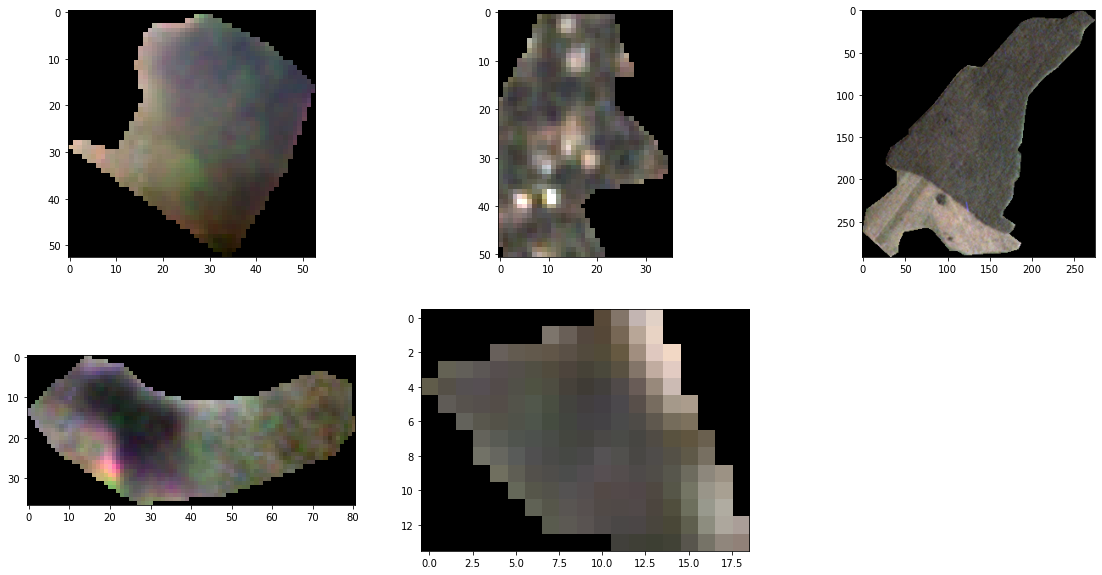

In [66]:
generate_corrected_images(FORESTS_TIF_PATH)

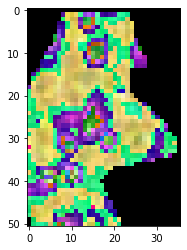

In [14]:
gdal_dataset = gdal.Open(os.path.join(FORESTS_TIF_PATH, 'way91308219.tif'))
rgb = get_rgb_from_tif(gdal_dataset, i=1).astype(np.uint8)
plt.imshow(rgb)


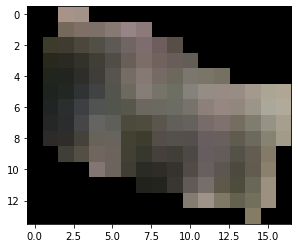

In [16]:
plt.imshow(test_image_calibrated)